In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Define months
months = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')
monthly_data = []

for month_start in months:
    n_samples = np.random.randint(300_000, 500_000)  # rows per month
    df = pd.DataFrame({
        'month': month_start.strftime('%Y-%m'),
        'app_starts': np.random.randint(1, 5, n_samples),
        'app_submits': np.random.randint(0, 2, n_samples),
        'insta_approvals': np.random.randint(0, 2, n_samples),
        'device_type': np.random.choice(['Mobile', 'Desktop'], n_samples, p=[0.6, 0.4]),
        'marketing_channel': np.random.choice(
            ['QR_Code', 'Shopping_cart', 'Credit_Landing_Page', 'Checkout', 'Home_Page', 'Email'], n_samples),
        'used_prefill': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'time_on_page_seconds': np.random.exponential(scale=120, size=n_samples).astype(int),
        'pages_visited': np.random.randint(1, 15, n_samples),
        'form_errors_encountered': np.random.choice(
            ['SSN_mismatch', 'Dead_Clicks', 'Page_Load', 'Page_Scroll', 'Chars_Exceeded', 'None'],
            n_samples, p=[0.05, 0.05, 0.05, 0.05, 0.05, 0.75])
    })

    # Target variable
    df['abandoned_application'] = (
        (df['device_type'] == 'Mobile').astype(int) * 0.15 +
        (df['used_prefill'] == 0).astype(int) * 0.10 +
        (df['form_errors_encountered'] != 'None').astype(int) * 0.20 +
        (df['time_on_page_seconds'] < 30).astype(int) * 0.05 +
        (df['app_submits'] == 0).astype(int) * 0.10 +
        np.random.rand(n_samples) * 0.1
    ) > 0.25
    df['abandoned_application'] = df['abandoned_application'].astype(int)

    monthly_data.append(df)

# Combine all months
full_data = pd.concat(monthly_data, ignore_index=True)
print(full_data.shape)
full_data

(5211764, 11)


,month,app_starts,app_submits,insta_approvals,device_type,marketing_channel,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application
0,2024-01,4,1,0,Mobile,Home_Page,0,33,13,None,1
1,2024-01,1,1,1,Desktop,Home_Page,0,13,9,None,0
2,2024-01,3,0,1,Mobile,Shopping_cart,0,84,3,None,1
3,2024-01,3,1,0,Mobile,Checkout,1,3,13,None,1
4,2024-01,4,0,1,Mobile,Home_Page,1,18,4,None,1
...,...,...,...,...,...,...,...,...,...,...,...
5211759,2024-12,2,0,1,Mobile,Shopping_cart,1,28,11,None,1
5211760,2024-12,3,0,0,Mobile,Shopping_cart,0,174,10,None,1
5211761,2024-12,2,0,1,Desktop,Home_Page,0,383,10,Chars_Exceeded,1
5211762,2024-12,4,1,1,Mobile,QR_Code,0,161,13,Chars_Exceeded,1


In [ ]:
df = full_data.copy()

# --------------------------
# 1. Handle Categorical Features
# --------------------------

# Create dummies for device type and marketing channel
df = pd.get_dummies(df, columns=['device_type', 'marketing_channel'], drop_first=True)

# Create dummies for form errors (important for feature insights)
# Each error type becomes a binary column
df['error_SSN_mismatch'] = (df['form_errors_encountered'] == 'SSN_mismatch').astype(int)
df['error_Dead_Clicks'] = (df['form_errors_encountered'] == 'Dead_Clicks').astype(int)
df['error_Page_Load'] = (df['form_errors_encountered'] == 'Page_Load').astype(int)
df['error_Page_Scroll'] = (df['form_errors_encountered'] == 'Page_Scroll').astype(int)
df['error_Chars_Exceeded'] = (df['form_errors_encountered'] == 'Chars_Exceeded').astype(int)



df

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,marketing_channel_Credit_Landing_Page,marketing_channel_Email,marketing_channel_Home_Page,marketing_channel_QR_Code,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded
0,2024-01,4,1,0,0,33,13,None,1,True,False,False,True,False,False,0,0,0,0,0
1,2024-01,1,1,1,0,13,9,None,0,False,False,False,True,False,False,0,0,0,0,0
2,2024-01,3,0,1,0,84,3,None,1,True,False,False,False,False,True,0,0,0,0,0
3,2024-01,3,1,0,1,3,13,None,1,True,False,False,False,False,False,0,0,0,0,0
4,2024-01,4,0,1,1,18,4,None,1,True,False,False,True,False,False,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211759,2024-12,2,0,1,1,28,11,None,1,True,False,False,False,False,True,0,0,0,0,0
5211760,2024-12,3,0,0,0,174,10,None,1,True,False,False,False,False,True,0,0,0,0,0
5211761,2024-12,2,0,1,0,383,10,Chars_Exceeded,1,False,False,False,True,False,False,0,0,0,0,1
5211762,2024-12,4,1,1,0,161,13,Chars_Exceeded,1,True,False,False,False,True,False,0,0,0,0,1


In [ ]:
# --------------------------
# 1. Journey Metrics
# --------------------------
# Non-negative (ensure no negatives)
df['app_starts'] = df['app_starts'].clip(lower=0)
df['app_submits'] = df['app_submits'].clip(lower=0)
df['insta_approvals'] = df['insta_approvals'].clip(lower=0)

In [ ]:
# Derived ratios
df['Submission_rate'] = df['app_submits'] / df['app_starts']
df['Submission_rate'] = df['Submission_rate'].replace(np.inf, 0)  # avoid division by zero
df['InstantApproval_rate'] = df['insta_approvals'] / df['app_submits']
df['InstantApproval_rate'] = df['InstantApproval_rate'].replace(np.inf, 0)

df.head(5)

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,...,marketing_channel_Home_Page,marketing_channel_QR_Code,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate
0,2024-01,4,1,0,0,33,13,None,1,True,...,True,False,False,0,0,0,0,0,0.250000,0.0
1,2024-01,1,1,1,0,13,9,None,0,False,...,True,False,False,0,0,0,0,0,1.000000,1.0
2,2024-01,3,0,1,0,84,3,None,1,True,...,False,False,True,0,0,0,0,0,0.000000,0.0
3,2024-01,3,1,0,1,3,13,None,1,True,...,False,False,False,0,0,0,0,0,0.333333,0.0
4,2024-01,4,0,1,1,18,4,None,1,True,...,True,False,False,0,0,0,0,0,0.000000,0.0


In [ ]:
# --------------------------
# 2. Page Behavior
# --------------------------
df['avg_time_per_page'] = df['time_on_page_seconds'] / df['pages_visited']
df['high_time_flag'] = (df['time_on_page_seconds'] > 50).astype(int)

df.head(5)

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,...,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate,avg_time_per_page,high_time_flag
0,2024-01,4,1,0,0,33,13,None,1,True,...,False,0,0,0,0,0,0.250000,0.0,2.538462,0
1,2024-01,1,1,1,0,13,9,None,0,False,...,False,0,0,0,0,0,1.000000,1.0,1.444444,0
2,2024-01,3,0,1,0,84,3,None,1,True,...,True,0,0,0,0,0,0.000000,0.0,28.000000,1
3,2024-01,3,1,0,1,3,13,None,1,True,...,False,0,0,0,0,0,0.333333,0.0,0.230769,0
4,2024-01,4,0,1,1,18,4,None,1,True,...,False,0,0,0,0,0,0.000000,0.0,4.500000,0


In [ ]:
# --------------------------
# 3. Form Errors
# --------------------------
error_types = ['SSN_mismatch', 'Dead_Clicks', 'Page_Load', 'Page_Scroll', 'Chars_Exceeded']
for error in error_types:
    df[f'error_{error}'] = (df['form_errors_encountered'] == error).astype(int)

# Aggregate error features
df['total_errors'] = df[[f'error_{e}' for e in error_types]].sum(axis=1)
df['any_error_flag'] = (df['total_errors'] > 0).astype(int)

In [ ]:
# --------------------------
# 4. Scaling Numerical Features (Optional for modeling)
# --------------------------
from sklearn.preprocessing import StandardScaler
numerical_features = ['time_on_page_seconds', 'pages_visited', 'avg_time_per_page',
                      'Submission_rate', 'InstantApproval_rate', 'app_starts', 'app_submits', 'insta_approvals', 'total_errors']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Drop original form_errors_encountered column
df.drop('form_errors_encountered', axis=1, inplace=True)
df.head()

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,abandoned_application,device_type_Mobile,marketing_channel_Credit_Landing_Page,...,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate,avg_time_per_page,high_time_flag,total_errors,any_error_flag
0,2024-01,1.341503,1.00036,-0.999944,0,-0.720969,1.364061,1,True,False,...,0,0,0,0,-0.031069,-0.707176,-0.508209,0,-0.577584,0
1,2024-01,-1.341772,1.00036,1.000056,0,-0.887776,0.372014,0,False,False,...,0,0,0,0,2.229005,1.414076,-0.530247,0,-0.577584,0
2,2024-01,0.447078,-0.99964,1.000056,0,-0.295610,-1.116057,1,True,False,...,0,0,0,0,-0.784428,-0.707176,0.004685,1,-0.577584,0
3,2024-01,0.447078,1.00036,-0.999944,1,-0.971179,1.364061,1,True,False,...,0,0,0,0,0.220050,-0.707176,-0.554695,0,-0.577584,0
4,2024-01,1.341503,-0.99964,1.000056,1,-0.846074,-0.868045,1,True,False,...,0,0,0,0,-0.784428,-0.707176,-0.468696,0,-0.577584,0


In [ ]:
device_summary = df.groupby('device_type_Mobile')['abandoned_application'].mean()
marketing_summary = df[[c for c in df.columns if 'marketing_channel' in c] + ['abandoned_application']].mean().sort_values(ascending=False)
print("Abandonment by Device:\n", device_summary)
print("Abandonment by Marketing Channel:\n", marketing_summary)

Abandonment by Device:
 device_type_Mobile
False    0.396326
True     0.900060
Name: abandoned_application, dtype: float64
Abandonment by Marketing Channel:
 abandoned_application                    0.698575
marketing_channel_Email                  0.166671
marketing_channel_Home_Page              0.166665
marketing_channel_QR_Code                0.166647
marketing_channel_Credit_Landing_Page    0.166603
marketing_channel_Shopping_cart          0.166457
dtype: float64


In [ ]:
df = full_data.copy()

# --------------------------
# 1. Handle Categorical Features
# --------------------------

# Create dummies for device type and marketing channel
df = pd.get_dummies(df, columns=['device_type', 'marketing_channel'], drop_first=True)

# Create dummies for form errors (important for feature insights)
# Each error type becomes a binary column
df['error_SSN_mismatch'] = (df['form_errors_encountered'] == 'SSN_mismatch').astype(int)
df['error_Dead_Clicks'] = (df['form_errors_encountered'] == 'Dead_Clicks').astype(int)
df['error_Page_Load'] = (df['form_errors_encountered'] == 'Page_Load').astype(int)
df['error_Page_Scroll'] = (df['form_errors_encountered'] == 'Page_Scroll').astype(int)
df['error_Chars_Exceeded'] = (df['form_errors_encountered'] == 'Chars_Exceeded').astype(int)



df

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,marketing_channel_Credit_Landing_Page,marketing_channel_Email,marketing_channel_Home_Page,marketing_channel_QR_Code,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded
0,2024-01,4,1,0,0,33,13,None,1,True,False,False,True,False,False,0,0,0,0,0
1,2024-01,1,1,1,0,13,9,None,0,False,False,False,True,False,False,0,0,0,0,0
2,2024-01,3,0,1,0,84,3,None,1,True,False,False,False,False,True,0,0,0,0,0
3,2024-01,3,1,0,1,3,13,None,1,True,False,False,False,False,False,0,0,0,0,0
4,2024-01,4,0,1,1,18,4,None,1,True,False,False,True,False,False,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211759,2024-12,2,0,1,1,28,11,None,1,True,False,False,False,False,True,0,0,0,0,0
5211760,2024-12,3,0,0,0,174,10,None,1,True,False,False,False,False,True,0,0,0,0,0
5211761,2024-12,2,0,1,0,383,10,Chars_Exceeded,1,False,False,False,True,False,False,0,0,0,0,1
5211762,2024-12,4,1,1,0,161,13,Chars_Exceeded,1,True,False,False,False,True,False,0,0,0,0,1


In [ ]:
# --------------------------
# 2. Aggregate Features (Session-level / Monthly Insights)
# --------------------------

# Example: Total app starts per month
monthly_starts = df.groupby('month')['app_starts'].sum().reset_index().rename(columns={'app_starts':'total_app_starts'})

# Example: Total app submits per month
monthly_submits = df.groupby('month')['app_submits'].sum().reset_index().rename(columns={'app_submits':'total_app_submits'})

# Example: Abandonment rate per month
monthly_abandonment = df.groupby('month')['abandoned_application'].mean().reset_index().rename(columns={'abandoned_application':'abandonment_rate'})

# Merge monthly summaries
monthly_summary = monthly_starts.merge(monthly_submits, on='month').merge(monthly_abandonment, on='month')
print(monthly_summary)


      month  total_app_starts  total_app_submits  abandonment_rate
0   2024-01           1054438             210587          0.700271
1   2024-02            798094             159844          0.697314
2   2024-03           1023901             204540          0.698421
3   2024-04           1086968             217508          0.697924
4   2024-05           1224070             244889          0.698275
5   2024-06           1028186             205699          0.698165
6   2024-07           1001912             200199          0.698474
7   2024-08           1113422             222150          0.699365
8   2024-09           1244395             248507          0.699188
9   2024-10           1147821             229483          0.699783
10  2024-11           1227503             245743          0.697420
11  2024-12           1079483             215794          0.697986


In [ ]:


# --------------------------
# 1. Journey Metrics
# --------------------------
# Non-negative (ensure no negatives)
df['app_starts'] = df['app_starts'].clip(lower=0)
df['app_submits'] = df['app_submits'].clip(lower=0)
df['insta_approvals'] = df['insta_approvals'].clip(lower=0)


In [ ]:
# Derived ratios
df['Submission_rate'] = df['app_submits'] / df['app_starts']
df['Submission_rate'] = df['Submission_rate'].replace(np.inf, 0)  # avoid division by zero
df['InstantApproval_rate'] = df['insta_approvals'] / df['app_submits']
df['InstantApproval_rate'] = df['InstantApproval_rate'].replace(np.inf, 0)

df.head(5)

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,...,marketing_channel_Home_Page,marketing_channel_QR_Code,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate
0,2024-01,4,1,0,0,33,13,None,1,True,...,True,False,False,0,0,0,0,0,0.250000,0.0
1,2024-01,1,1,1,0,13,9,None,0,False,...,True,False,False,0,0,0,0,0,1.000000,1.0
2,2024-01,3,0,1,0,84,3,None,1,True,...,False,False,True,0,0,0,0,0,0.000000,0.0
3,2024-01,3,1,0,1,3,13,None,1,True,...,False,False,False,0,0,0,0,0,0.333333,0.0
4,2024-01,4,0,1,1,18,4,None,1,True,...,True,False,False,0,0,0,0,0,0.000000,0.0


In [ ]:
# --------------------------
# 2. Page Behavior
# --------------------------
df['avg_time_per_page'] = df['time_on_page_seconds'] / df['pages_visited']
df['high_time_flag'] = (df['time_on_page_seconds'] > 50).astype(int)

df.head(5)

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,form_errors_encountered,abandoned_application,device_type_Mobile,...,marketing_channel_Shopping_cart,error_SSN_mismatch,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate,avg_time_per_page,high_time_flag
0,2024-01,4,1,0,0,33,13,None,1,True,...,False,0,0,0,0,0,0.250000,0.0,2.538462,0
1,2024-01,1,1,1,0,13,9,None,0,False,...,False,0,0,0,0,0,1.000000,1.0,1.444444,0
2,2024-01,3,0,1,0,84,3,None,1,True,...,True,0,0,0,0,0,0.000000,0.0,28.000000,1
3,2024-01,3,1,0,1,3,13,None,1,True,...,False,0,0,0,0,0,0.333333,0.0,0.230769,0
4,2024-01,4,0,1,1,18,4,None,1,True,...,False,0,0,0,0,0,0.000000,0.0,4.500000,0


# **Journey Metrics and Page Behavior Insights**

* **Submission Rate:** Analyze the average submission rate to understand overall application completion efficiency. A low rate might indicate issues early in the funnel.
* **Instant Approval Rate:** Monitor the instant approval rate as a key success metric. Investigate factors influencing this rate, such as data quality or system performance.
* **Time on Page:** Examine the distribution of time users spend on pages. High average time per page could suggest complex forms or engaged users, while low time could indicate confusion or abandonment.
* **Average Time per Page vs. Abandonment:** Compare average time spent per page with abandonment rates. Are users spending a long time on pages and then abandoning? This might point to specific page-level issues.
* **Pages Visited:** Analyze the number of pages visited. A high number of pages visited before abandonment might indicate users are exploring but not finding what they need, or encountering issues across multiple steps.
* **Correlation with Abandonment:** Investigate the correlation between the derived metrics (submission rate, instant approval rate, time on page, pages visited) and the `abandoned_application` target variable to identify the strongest predictors of abandonment.

**Recommendations:**

* **Optimize High-Abandonment Pages:** Identify pages with high abandonment rates and analyze user behavior on those pages (e.g., time spent, clicks, scroll depth) to pinpoint issues.
* **Simplify Application Flow:** If the submission rate is low, review the application process for complexity or unnecessary steps that might be causing users to drop off.
* **Improve Instant Approval Factors:** If the instant approval rate is low, examine the criteria and process for instant approvals to identify bottlenecks or areas for improvement.
* **Address Time-on-Page Issues:** For pages where users spend a long time but abandon, consider simplifying content, improving navigation, or providing clearer instructions. Conversely, for pages with very low time on page and high abandonment, the content might not be engaging or relevant.
* **Streamline Multi-Page Journeys:** If users visit many pages before abandoning, consider consolidating steps, improving internal linking, or providing progress indicators to guide them through the process.

In [ ]:
# --------------------------
# 3. Form Errors
# --------------------------
error_types = ['SSN_mismatch', 'Dead_Clicks', 'Page_Load', 'Page_Scroll', 'Chars_Exceeded']
for error in error_types:
    df[f'error_{error}'] = (df['form_errors_encountered'] == error).astype(int)

# Aggregate error features
df['total_errors'] = df[[f'error_{e}' for e in error_types]].sum(axis=1)
df['any_error_flag'] = (df['total_errors'] > 0).astype(int)

In [ ]:
# --------------------------
# 4. Scaling Numerical Features (Optional for modeling)
# --------------------------
from sklearn.preprocessing import StandardScaler
numerical_features = ['time_on_page_seconds', 'pages_visited', 'avg_time_per_page',
                      'Submission_rate', 'InstantApproval_rate', 'app_starts', 'app_submits', 'insta_approvals', 'total_errors']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Drop original form_errors_encountered column
df.drop('form_errors_encountered', axis=1, inplace=True)
df.head()

,month,app_starts,app_submits,insta_approvals,used_prefill,time_on_page_seconds,pages_visited,abandoned_application,device_type_Mobile,marketing_channel_Credit_Landing_Page,...,error_Dead_Clicks,error_Page_Load,error_Page_Scroll,error_Chars_Exceeded,Submission_rate,InstantApproval_rate,avg_time_per_page,high_time_flag,total_errors,any_error_flag
0,2024-01,1.341503,1.00036,-0.999944,0,-0.720969,1.364061,1,True,False,...,0,0,0,0,-0.031069,-0.707176,-0.508209,0,-0.577584,0
1,2024-01,-1.341772,1.00036,1.000056,0,-0.887776,0.372014,0,False,False,...,0,0,0,0,2.229005,1.414076,-0.530247,0,-0.577584,0
2,2024-01,0.447078,-0.99964,1.000056,0,-0.295610,-1.116057,1,True,False,...,0,0,0,0,-0.784428,-0.707176,0.004685,1,-0.577584,0
3,2024-01,0.447078,1.00036,-0.999944,1,-0.971179,1.364061,1,True,False,...,0,0,0,0,0.220050,-0.707176,-0.554695,0,-0.577584,0
4,2024-01,1.341503,-0.99964,1.000056,1,-0.846074,-0.868045,1,True,False,...,0,0,0,0,-0.784428,-0.707176,-0.468696,0,-0.577584,0


In [ ]:
# Monthly aggregation
monthly_summary = df.groupby('month').agg(
    total_app_starts=('app_starts', 'sum'),
    total_app_submits=('app_submits', 'sum'),
    total_insta_approvals=('insta_approvals', 'sum'),
    avg_submit_ratio=('Submission_rate', 'mean'),
    avg_approval_ratio=('InstantApproval_rate', 'mean'),
    avg_time_on_page=('time_on_page_seconds', 'mean'),
    avg_pages_visited=('pages_visited', 'mean'),
    total_errors=('total_errors', 'sum'),
    abandonment_rate=('abandoned_application', 'mean')
).reset_index()

monthly_summary


,month,total_app_starts,total_app_submits,total_insta_approvals,avg_submit_ratio,avg_approval_ratio,avg_time_on_page,avg_pages_visited,total_errors,abandonment_rate
0,2024-01,-465.453227,-631.952265,-348.520845,0.000746,-0.000450,-0.000731,-0.000306,-310.647267,0.700271
1,2024-02,-155.602144,515.051840,-400.233747,0.002496,0.000856,-0.000725,-0.001396,-1067.787291,0.697314
2,2024-03,-537.159122,-548.341905,378.801309,-0.000995,-0.002837,-0.001328,0.000096,-150.525263,0.698421
3,2024-04,205.893640,503.628073,-756.813563,0.000357,0.000646,0.002090,0.000308,-212.931273,0.697924
4,2024-05,180.187547,436.392283,-352.761580,-0.000022,0.001084,0.002641,0.000419,-52.632475,0.698275
5,2024-06,871.414809,686.048782,92.861626,-0.000109,0.001624,-0.000765,0.000220,-1042.153664,0.698165
6,2024-07,-143.748213,-262.574485,-350.697868,0.000231,0.000127,0.000474,0.001642,-2.495931,0.698474
7,2024-08,232.647814,-777.563591,576.774534,-0.002685,0.001178,-0.001928,-0.000558,630.166569,0.699365
8,2024-09,-731.037198,-861.531590,-347.286553,-0.001626,-0.001515,0.003124,-0.003059,1199.858766,0.699188
9,2024-10,220.959590,129.396169,269.540409,-0.000331,-0.000540,-0.001437,0.000128,1608.949123,0.699783


In [ ]:
error_summary = df[[f'error_{e}' for e in error_types] + ['abandoned_application']].sum()
error_impact = df.groupby('any_error_flag')['abandoned_application'].mean()
print("Error Impact on Abandonment:\n", error_impact)


Error Impact on Abandonment:
 any_error_flag
0    0.605778
1    0.976742
Name: abandoned_application, dtype: float64


In [ ]:
device_summary = df.groupby('device_type_Mobile')['abandoned_application'].mean()
marketing_summary = df[[c for c in df.columns if 'marketing_channel' in c] + ['abandoned_application']].mean().sort_values(ascending=False)
print("Abandonment by Device:\n", device_summary)
print("Abandonment by Marketing Channel:\n", marketing_summary)

Abandonment by Device:
 device_type_Mobile
False    0.396326
True     0.900060
Name: abandoned_application, dtype: float64
Abandonment by Marketing Channel:
 abandoned_application                    0.698575
marketing_channel_Email                  0.166671
marketing_channel_Home_Page              0.166665
marketing_channel_QR_Code                0.166647
marketing_channel_Credit_Landing_Page    0.166603
marketing_channel_Shopping_cart          0.166457
dtype: float64


In [ ]:
journey_summary = df.groupby(pd.cut(df['Submission_rate'], bins=[-0.01,0.3,0.6,1.0]))['abandoned_application'].mean()
print("Abandonment vs Submit Ratio:\n", journey_summary)


Abandonment vs Submit Ratio:
 Submission_rate
(-0.01, 0.3]    0.568919
(0.3, 0.6]           NaN
(0.6, 1.0]      0.568503
Name: abandoned_application, dtype: float64


/tmp/ipython-input-3069687731.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journey_summary = df.groupby(pd.cut(df['Submission_rate'], bins=[-0.01,0.3,0.6,1.0]))['abandoned_application'].mean()


# **High-Level Recommendations from All Features**

| Feature Group        | Insight                                         | Recommendation                                                     |
| -------------------- | ----------------------------------------------- | ------------------------------------------------------------------ |
| Form Errors          | Users with errors 3–5x more likely to abandon   | Real-time error detection & guidance                               |
| Device               | Mobile users higher abandonment                 | Mobile UX improvements & targeted support                          |
| Marketing Channel    | Certain channels show high drop-off             | Optimize landing pages, pre-fill, or campaign design               |
| App Starts / Submits | Low submit ratio → high abandonment             | Trigger live chat or guided assistance for low submit\_ratio users |
| Time/Page Behavior   | Extremely low time or very high time → friction | Improve page load & form clarity                                   |
| Instant Approvals    | Low approval ratio → reduces motivation         | Simplify approval process or pre-validate eligibility              |


# **Step 3: Exploratory Data Analysis (EDA) & Insights**

Here, we’ll visualize and quantify relationships between features and the target (abandoned_application) to generate actionable insights and recommendations. We’ll cover:

Abandonment by device type

Abandonment by marketing channel

Abandonment by form errors

Abandonment by journey metrics (app_starts, app_submits, insta_approvals)

Abandonment vs time on page / pages visited

Monthly trends

Abandonment by Device:
 device_type_Mobile
False    0.396326
True     0.900060
Name: abandoned_application, dtype: float64


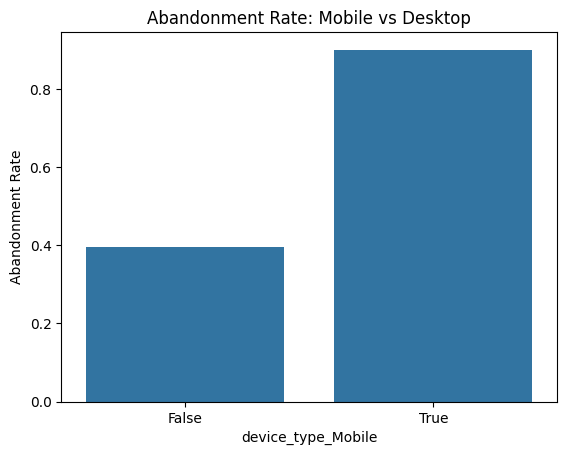

/tmp/ipython-input-836814586.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  channel_abandon[col] = df.groupby(col)['abandoned_application'].mean()[1]  # 1 = channel used


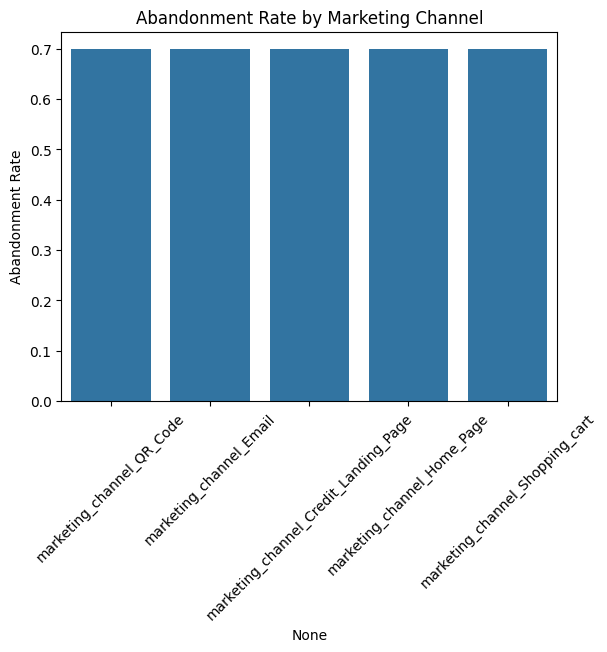

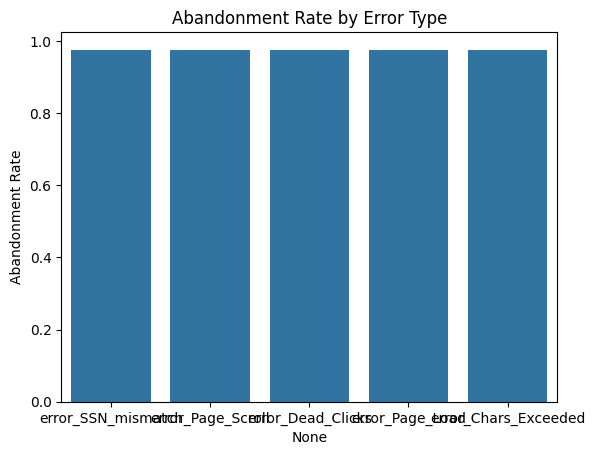

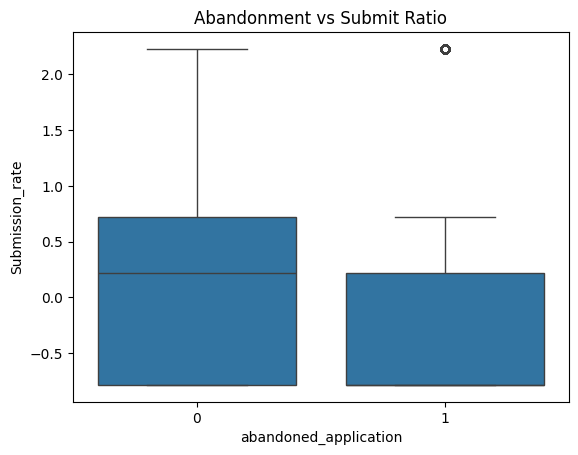

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Device Type Analysis
# --------------------------
device_abandon = df.groupby('device_type_Mobile')['abandoned_application'].mean()
print("Abandonment by Device:\n", device_abandon)

sns.barplot(x=device_abandon.index, y=device_abandon.values)
plt.title("Abandonment Rate: Mobile vs Desktop")
plt.ylabel("Abandonment Rate")
plt.show()

# Insight: Mobile users usually have higher abandonment → optimize mobile UX

# --------------------------
# 2. Marketing Channel Analysis
# --------------------------
marketing_cols = [c for c in df.columns if 'marketing_channel' in c]
marketing_abandon = df[marketing_cols + ['abandoned_application']].groupby(marketing_cols).mean()
# For simplicity, let's visualize mean abandonment per channel
channel_abandon = {}
for col in marketing_cols:
    channel_abandon[col] = df.groupby(col)['abandoned_application'].mean()[1]  # 1 = channel used
channel_abandon = pd.Series(channel_abandon).sort_values(ascending=False)

sns.barplot(x=channel_abandon.index, y=channel_abandon.values)
plt.title("Abandonment Rate by Marketing Channel")
plt.ylabel("Abandonment Rate")
plt.xticks(rotation=45)
plt.show()

# Recommendation: Focus optimization on channels with high abandonment

# --------------------------
# 3. Form Errors Analysis
# --------------------------
error_cols = [f'error_{e}' for e in ['SSN_mismatch', 'Dead_Clicks', 'Page_Load', 'Page_Scroll', 'Chars_Exceeded']]
error_abandon = df[error_cols + ['abandoned_application']].groupby(error_cols).mean()
error_rate = {}
for col in error_cols:
    error_rate[col] = df.groupby(col)['abandoned_application'].mean()[1]  # 1 = error occurred
error_rate = pd.Series(error_rate).sort_values(ascending=False)

sns.barplot(x=error_rate.index, y=error_rate.values)
plt.title("Abandonment Rate by Error Type")
plt.ylabel("Abandonment Rate")
plt.show()

# Insight: Certain errors (SSN_mismatch, Page_Load) drastically increase abandonment

# --------------------------
# 4. Journey Metrics Analysis
# --------------------------
sns.boxplot(x='abandoned_application', y='Submission_rate', data=df)
plt.title("Abandonment vs Submit Ratio")
plt.show()

sns.boxplot(x='abandoned_application', y='InstantApproval_rate', data=df)
plt.title("Abandonment vs Approval Ratio")
plt.show()

sns.boxplot(x='abandoned_application', y='app_starts', data=df)
plt.title("Abandonment vs App Starts")
plt.show()

# Insight: Low submit_ratio, low approval_ratio → higher abandonment

# --------------------------
# 5. Time/Page Behavior
# --------------------------
sns.boxplot(x='abandoned_application', y='avg_time_per_page', data=df)
plt.title("Abandonment vs Avg Time per Page")
plt.show()

sns.boxplot(x='abandoned_application', y='pages_visited', data=df)
plt.title("Abandonment vs Pages Visited")
plt.show()

# Insight: Extremely low or extremely high time → friction points

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report
import pandas as pd
import numpy as np

# Features and Target
X = df.drop(['month', 'abandoned_application'], axis=1)
y = df['abandoned_application']

# Impute missing values with the mean
X = X.fillna(X.mean())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 1. Logistic Regression
# --------------------------
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions & probabilities
y_pred_proba_log = log_model.predict_proba(X_test)[:,1]
y_pred_log = (y_pred_proba_log > 0.7).astype(int)  # 70% threshold for high-risk

# Evaluation
print("Logistic Regression Metrics")
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))

# Odds Ratios (interpretation)
odds_ratios = pd.Series(np.exp(log_model.coef_[0]), index=X.columns).sort_values(ascending=False)
print("Top Logistic Regression Feature Odds Ratios:\n", odds_ratios.head(10))

# --------------------------
# 2. XGBoost
# --------------------------
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions & probabilities
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
y_pred_xgb = (y_pred_proba_xgb > 0.7).astype(int)

# Evaluation
print("\nXGBoost Metrics")
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))

# Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top XGBoost Features:\n", xgb_importance.head(10))

# --------------------------
# 3. Risk Scoring for Users
# --------------------------
df['risk_score'] = xgb_model.predict_proba(X)[:,1]
df['high_risk_flag'] = (df['risk_score'] > 0.7).astype(int)

Logistic Regression Metrics
AUC-ROC: 0.9928101243991495
Precision: 0.9885916343502398
Recall: 0.9324261264599717
Top Logistic Regression Feature Odds Ratios:
 device_type_Mobile      6.933020e+09
total_errors            7.766953e+03
any_error_flag          6.390670e+01
error_Page_Load         2.343878e+00
error_Page_Scroll       2.342466e+00
error_Dead_Clicks       2.327150e+00
error_SSN_mismatch      2.305913e+00
error_Chars_Exceeded    2.169056e+00
insta_approvals         1.002068e+00
app_starts              1.001085e+00
dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:55:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Metrics
AUC-ROC: 0.9929879486630191
Precision: 1.0
Recall: 0.9216617943755919
Top XGBoost Features:
 device_type_Mobile                 0.515241
app_submits                        0.180629
total_errors                       0.157965
used_prefill                       0.133607
time_on_page_seconds               0.012065
marketing_channel_Shopping_cart    0.000036
error_Dead_Clicks                  0.000033
pages_visited                      0.000033
marketing_channel_Home_Page        0.000033
error_Page_Scroll                  0.000032
dtype: float32


         risk_score  high_risk_flag  app_starts  app_submits  insta_approvals  \
829196     0.999997               1   -1.341772     -0.99964        -0.999944   
4583349    0.999997               1   -1.341772     -0.99964        -0.999944   
751988     0.999997               1   -1.341772     -0.99964         1.000056   
3957005    0.999997               1   -1.341772     -0.99964        -0.999944   
1396523    0.999997               1   -1.341772     -0.99964        -0.999944   
4281772    0.999997               1   -1.341772     -0.99964         1.000056   
3612902    0.999997               1   -0.447347     -0.99964        -0.999944   
2206344    0.999997               1   -1.341772     -0.99964        -0.999944   
3869260    0.999997               1   -1.341772     -0.99964        -0.999944   
1471645    0.999997               1   -1.341772     -0.99964        -0.999944   
2042509    0.999997               1   -0.447347     -0.99964         1.000056   
2202279    0.999997         

/tmp/ipython-input-2585527739.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.head(10).values, y=feature_importance.head(10).index, palette="viridis")


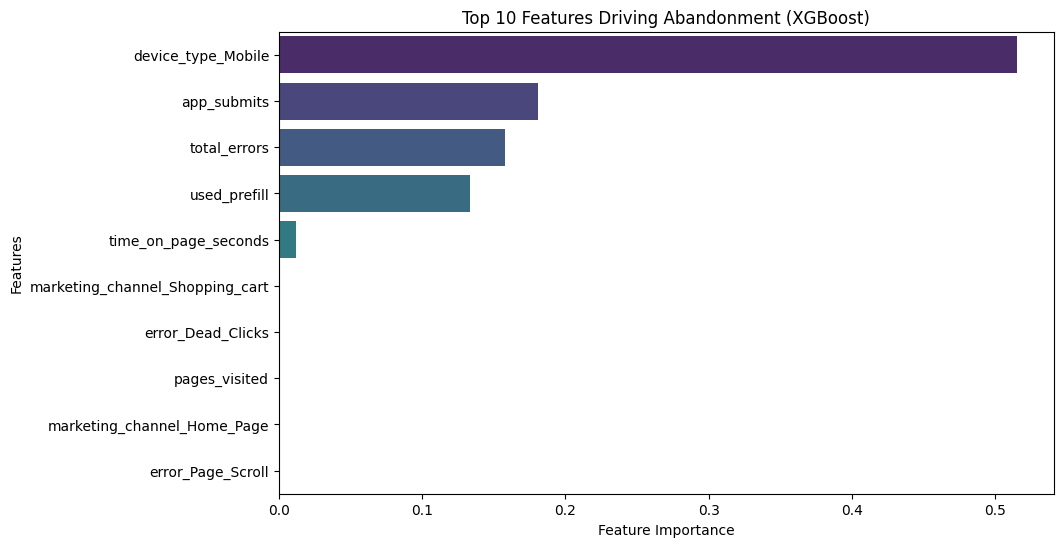

Risk Scoring Summary:
 {'Total Users': 5211764, 'High Risk Users (>70% score)': np.int64(3357854), 'Average Risk Score': np.float32(0.69848), 'Average Submit Ratio (High Risk)': np.float64(-0.12476001547353772), 'Average Errors (High Risk)': np.float64(0.3701137690918069)}


In [ ]:


# Top 10 high-risk users (example)
risk_table = df[['risk_score', 'high_risk_flag'] + ['app_starts', 'app_submits', 'insta_approvals', 'Submission_rate', 'InstantApproval_rate', 'any_error_flag', 'device_type_Mobile']].sort_values(by='risk_score', ascending=False).head(20)
print(risk_table)

# --------------------------
# 3. Feature Importance
# --------------------------
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Features Driving Abandonment:\n", feature_importance.head(10))

# Visualize Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.head(10).values, y=feature_importance.head(10).index, palette="viridis")
plt.title("Top 10 Features Driving Abandonment (XGBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# --------------------------
# 4. Summary Statistics for Deck
# --------------------------
summary = {
    'Total Users': len(df),
    'High Risk Users (>70% score)': df['high_risk_flag'].sum(),
    'Average Risk Score': df['risk_score'].mean(),
    'Average Submit Ratio (High Risk)': df.loc[df['high_risk_flag']==1, 'Submission_rate'].mean(),
    'Average Errors (High Risk)': df.loc[df['high_risk_flag']==1, 'any_error_flag'].mean()
}
print("Risk Scoring Summary:\n", summary)
